In [1]:
# load ACLED data

from protest_impact.data.protests.sources.acled import load_acled

acled = load_acled()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,region_code,size
10141,2020-12-04,Peaceful protest,NaN,Nordrhein-Westfalen,Dusseldorf,"On 4 December 2020, a protest took place outsi...",NW,NaN
4309,2022-01-17,Peaceful protest,NaN,Berlin,Berlin - Reinickendorf,"On 17 January 2022, in the evening, 900 people...",BE,900.0
12993,2020-05-16,Peaceful protest,NaN,Sachsen,Dresden,"On 16 May 2020, around 200 people protested in...",SN,200.0
11988,2020-07-22,Peaceful protest,Greenpeace,Berlin,Berlin,"On 22 July 2020, around one dozen Greenpeace a...",BE,12.0
2150,2022-05-13,Peaceful protest,FFF: Fridays for Future; Students (Germany),Bayern,Wurzburg,"On 13 May 2022, FFF members camped in various ...",BY,NaN


In [2]:
# TODO: there is a problem with baden-württemberg and mecklenburg-vorpommern

acled = acled[
    (acled["admin1"] != "Baden-Württemberg")
    & (acled["admin1"] != "Mecklenburg-Vorpommern")
]

## Coverage information from Mediacloud

### Regions

In [13]:
from protest_impact.data.news.config import region_tags

region_tags

{'germany_national': 34412409,
 'germany_regional': 38379816,
 'baden-württemberg': 262985085,
 'bayern': 38379825,
 'berlin': 38379823,
 'brandenburg': 38379827,
 'bremen': 38379829,
 'hamburg': 38379819,
 'hessen': 38379821,
 'mecklenburg-vorpommern': 262985084,
 'niedersachsen': 38379831,
 'nordrhein-westfalen': 38379817,
 'rheinland-pfalz': 38379833,
 'saarland': 38379835,
 'sachsen': 38379837,
 'sachsen-anhalt': 38379839,
 'schleswig-holstein': 38379841,
 'thüringen': 38379843}

In [14]:
import random

random.seed(20230227)
ignore = [
    "germany_national",
    "germany_regional",
    "baden-württemberg",
    "mecklenburg-vorpommern",
]
sampled_regions = random.sample(sorted(set(region_tags) - set(ignore)), 4)
sampled_regions

['niedersachsen', 'nordrhein-westfalen', 'sachsen', 'hamburg']

### Approach 1: General word counts for a given period

- 👍 relatively fast (13s for vocab of 5000 of a 1000 sentence sample)
- ❓ duration does not scale linearly, with vocab size of 5000 we have:
  - 1000 sentences: 13s
  - 2000 sentences: 34s
  - 3000 sentences: 50s
  - 4000 sentences: 75s
  - 5000 sentences: 75s, but sometimes >120s
- 👍 gets counts for a large vocabulary
- 👍 can be run multiple times with small sample size (with different seeds) to estimate **uncertainty**
- 👎 needs to be called for every event, 1x for the period before, 1x for the period afterwards, and possibly multiple times for multiple time windows
- ✅ relevant keywords words need not be pre-specified, **unsupervised** impact estimation possible

In [15]:
from os import environ
from pprint import pprint

from dotenv import load_dotenv

from protest_impact.util import get_cached

load_dotenv()


def get_general_word_counts(region, start_date, end_date):
    response = get_cached(
        "https://api.mediacloud.org/api/v2/wc/list/",
        params={
            "q": f"tags_id_media:{region_tags[region]}",
            "fq": f"publish_date:[{start_date}T00:00:00Z TO {end_date}T00:00:00Z]",
            "num_words": 5000,
            "sample_size": 4000,
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"},
    )
    return response.json()


for region in sampled_regions:
    print(region)
    result = get_general_word_counts(region, "2020-01-01", "2021-01-01")
    print(len(result))
    for a in result[:15]:
        print(a["count"], a["term"])
    pprint([a for a in result if "klima" in a["term"]])
    print()

niedersachsen
5000
518 qui
390 ut
387 aut
385 ejf
349 efs
345 schon
336 est
298 dolores
278 voluptatem
276 quia
264 deutschen
263 deutschland
261 euro
259 spielen
259 prozent
[{'count': 10, 'stem': 'klimaschutz', 'term': 'klimaschutz'},
 {'count': 7, 'stem': 'klimawandel', 'term': 'klimawandel'},
 {'count': 7, 'stem': 'klima', 'term': 'klima'}]

nordrhein-westfalen
5000
997 ejf
976 efs
709 dmbttµ
649 voe
591 jo
460 uhr
427 ejw
388 efo
385 ebt
348 schon
311 deutschland
299 00jnh
285 gýs
283 00xxx
280 ft
[{'count': 13, 'stem': 'klimawandel', 'term': 'klimawandel'},
 {'count': 6, 'stem': 'klimaschutz', 'term': 'klimaschutz'},
 {'count': 6, 'stem': 'klima', 'term': 'klima'}]

sachsen
5000
439 schon
361 spielen
356 deutschen
306 prozent
294 euro
275 leipzig
273 deutschland
266 jährige
255 wochen
253 fall
250 dpa
248 alte
239 land
225 rund
219 großen
[{'count': 18, 'stem': 'klimawandel', 'term': 'klimawandel'},
 {'count': 18, 'stem': 'klimaschutz', 'term': 'klimaschutz'},
 {'count': 6, 'stem

The Latin words are most likely part of the [Lorem Ipsum](https://www.lipsum.com/) dummy text.

### Approach 2: Word matrices per story

1688


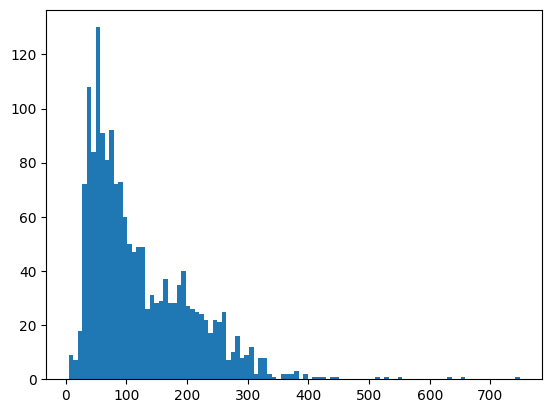

In [16]:
response = get_cached(
    "https://api.mediacloud.org/api/v2/stories_public/word_matrix/",
    params={
        "q": "media_id:69752",
        "fq": "publish_date:[2020-01-01T00:00:00Z TO 2023-01-01T00:00:00Z]",
        "key": environ["MEDIACLOUD_API_KEY"],
    },
    headers={"Accept": "application/json"},
)
result = response.json()
# list(result["word_matrix"].items())[:2]
print(len(result["word_matrix"]))
plt.hist([len(a) for a in result["word_matrix"].values()], bins=100)
plt.show()

In [17]:
word_list = result["word_list"]
word_matrix = result["word_matrix"]
word_matrix = {
    int(k): {word_list[int(k_)][1]: v_ for k_, v_ in v.items()}
    for k, v in word_matrix.items()
}

In [18]:
for story_id, word_list in list(word_matrix.items())[:3]:
    print(story_id)
    print(word_list)
    [print()]

1483914825
{'untersagt': 1, 'negativen': 1, 'dramatischen': 1, 'verursacht': 1, 'dpa': 1, 'folgen': 2, 'tierschützer': 1, 'orten': 1, 'tiere': 3, 'deutschen': 1, 'bonn': 1, 'fordern': 1, 'deutsche': 1, 'silvesterfeuerwerk': 2, 'tragödie': 1, 'schutzzonen': 1, 'lebten': 1, 'belege': 1, 'böllerei': 1, 'schrecklich': 1, 'unkontrollierte': 1, 'brückner': 1, 'feuerwerkskörper': 1, 'tierschutzbund': 2, 'zoo': 3, 'sicherheitszonen': 1, 'krefeld': 1, 'private': 1, 'kritisiert': 1, 'landwirtschaftliche': 1, 'james': 1, 'betrieb': 1, 'brand': 2, 'gefordert': 1, 'tierheim': 1, 'min': 1}

1483945263
{'wenigen': 1, 'person': 2, 'brach': 1, 'eisfläche': 4, 'cm': 1, 'vorsicht': 2, 'eis': 5, 'gewässern': 1, 'erfahren': 1, 'befreien': 1, 'meist': 1, 'passanten': 1, 'stark': 1, 'eintreffen': 1, 'unterkühlung': 1, 'langsam': 1, 'zogen': 1, 'aufmerksam': 1, 'ufer': 2, 'ausrüstung': 1, 'techniken': 1, 'dünne': 1, 'lief': 1, 'eindrucksvoll': 1, 'dauert': 1, 'bewegt': 1, 'übung': 1, 'notruf': 1, 'brüchige': 

### Approach 3: Daily counts for specific words

- 👎 A [data availability issue](https://mediacloud.org/news/2022/11/4/media-cloud-tools-update-for-november-2022#:~:text=trouble%20logging%20in.-,Data%20issues,-Media%20Cloud%20uses) with MediaCloud leads to another data representation issue, but can be worked around

In [117]:
from protest_impact.data.news.sources.mediacloud import get_regional_count_df


def get_count(
    term: str,
    region_tag: int,
    start_date: str = "2020-01-01",
    end_date: str = "2023-02-20",
):
    overall_count_df = get_regional_count_df("*", region_tag, start_date, end_date)
    overall_count_df = overall_count_df.rename(columns={"count": "overall_count"})
    count_df = get_regional_count_df(term, region_tag, start_date, end_date)
    count_df = count_df.rename(columns={"count": "term_count"})
    both_df = overall_count_df.merge(count_df, on="date", how="outer")
    both_df["term_count"] = both_df["term_count"].fillna(0)
    both_df["term_count"] = both_df["term_count"].astype(int)
    both_df["term_share"] = both_df["term_count"] / both_df["overall_count"]
    # fill missing dates with 0
    both_df = both_df.reindex(
        pd.date_range(start=start_date, end=end_date, freq="D"), fill_value=0
    )
    return both_df

In [118]:
for region in sampled_regions:
    print(region)
    df = get_count("klimaschutz", region_tags[region])
    print(df.sample(10, random_state=1))
    print()

niedersachsen
            overall_count  term_count  term_share
2022-07-23           1378          11    0.007983
2020-04-30           1719           5    0.002909
2021-11-25           3659          63    0.017218
2022-08-23           2258          15    0.006643
2023-01-06           2369          30    0.012664
2023-01-18           2753          22    0.007991
2020-05-15           1798          18    0.010011
2021-01-30           1704          11    0.006455
2020-07-13           2419          15    0.006201
2022-09-24           1392           5    0.003592

nordrhein-westfalen
            overall_count  term_count  term_share
2022-07-23           3233          39    0.012063
2020-04-30           2653           2    0.000754
2021-11-25           3538          61    0.017241
2022-08-23           5066          52    0.010265
2023-01-06           5098          41    0.008042
2023-01-18           5681          37    0.006513
2020-05-15           2228           4    0.001795
2021-01-30     